# Prophet 모델 이용 추세 파악

 성장 모형은 `linear`보다는 `logistic`일 때 더 기존 데이터 추세 반영이 잘잘 된다. 그런데, 전체적으로 봤을 때 EDA에서 매출액이 증가하는 추세를 logistic은 반영하지 못한다. logistic 추세도 전체적으로 증가하는 추세를 반영할 수 있도록 고민해야 한다.

 추세 자체는 기존의 EDA 통해 찾아낸 추세와 크게 다르지 않다. 다만, holiday를 반영해줄 수 있다.


In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

from fbprophet import Prophet

In [2]:
# 그래프 출력 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [3]:
# 경로 변경
os.chdir('/content/drive/My Drive/Big-Contest')
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [4]:
# 경로 설정
RAW_DATA = './data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'

In [5]:
# 데이터 로드 및 기본 전처리
data_raw = pd.read_excel(RAW_DATA, header=1)
data = data_raw[data_raw['상품군'] != '무형'] # 무형 상품군 제외
data['노출(분)'] = data['노출(분)'].fillna(method='ffill') # 노출 결측치 처리
data['취급액'] = data['취급액'].fillna(0) # 취급액 0원인 상품 처리
data = data[data['방송일시'].dt.year != 2020] # 2020년 데이터 제외
data = data.reset_index(drop=True)

In [6]:
# 판매량 컬럼 생성
data['판매량'] = data['취급액'] / data['판매단가']

In [7]:
# 집계 기준 컬럼 생성
data['날짜'] = data['방송일시'].dt.date
data['날짜시간'] = data['방송일시'].dt.floor('H')
data['날짜'] = pd.to_datetime(data['날짜'])
data['날짜시간'] = pd.to_datetime(data['날짜시간'])
data.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,날짜,날짜시간
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01,2019-01-01 06:00:00
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01,2019-01-01 06:00:00
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01,2019-01-01 06:00:00
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01,2019-01-01 06:00:00
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01,2019-01-01 06:00:00
5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,234.010025,2019-01-01,2019-01-01 06:00:00
6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000.0,115.576271,2019-01-01,2019-01-01 07:00:00
7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000.0,265.915254,2019-01-01,2019-01-01 07:00:00
8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,430.000000,2019-01-01,2019-01-01 07:00:00
9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000.0,269.332220,2019-01-01,2019-01-01 08:00:00


In [8]:
# 공휴일
holiday_df = pd.read_csv('./data/holiday_prophet_2차.csv')
holiday_df

,holiday,ds,lower_window,upper_window
0,신정,2019-01-01,0,2
1,연초,2019-01-01,0,16
2,연말,2019-12-31,-16,0
3,설날,2019-02-04,-2,2
4,설날,2019-02-05,-2,2
5,설날,2019-02-06,-2,2
6,설날기간,2019-02-04,-30,10
7,설날기간,2019-02-05,-30,10
8,설날기간,2019-02-06,-30,10
9,추석,2019-09-12,-2,2


## _1_. 일별 취급액 합계

- holiday effect(여러 가지 다 넣은 `holiday2` 반영하면 이상해진다.
- `yearly_effect` 반영하면 1월달은 작아지고 6월달로 갈수록 늘어난다. 반영 안 하면, 계속해서 늘어난다. 

In [9]:
# 일별 취급액 및 판매량 합계
daily = pd.DataFrame(data.groupby(by='날짜', as_index=True).agg({'취급액':'sum', '판매량':'sum'}))

# 취급액
scaler = StandardScaler()
scaler.fit(daily[['취급액']])
daily['취급액_scaled'] = scaler.transform(daily[['취급액']])
daily['취급액_log'] = np.log1p(daily['취급액'])

# 판매량
scaler = StandardScaler()
scaler.fit(daily[['판매량']])
daily['판매량_scaled'] = scaler.transform(daily[['판매량']])
daily['판매량_log'] = np.log1p(daily['판매량'])

In [10]:
# Prophet 모델에 맞게 데이터셋 구성
train = daily.reset_index(drop=False)[['날짜', '취급액']].rename(columns={'날짜':'ds', '취급액':'y'})

### linear: default 설정

In [16]:
# 공휴일, linear, year 1년치 추세 파악
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=183) # 6월까지
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


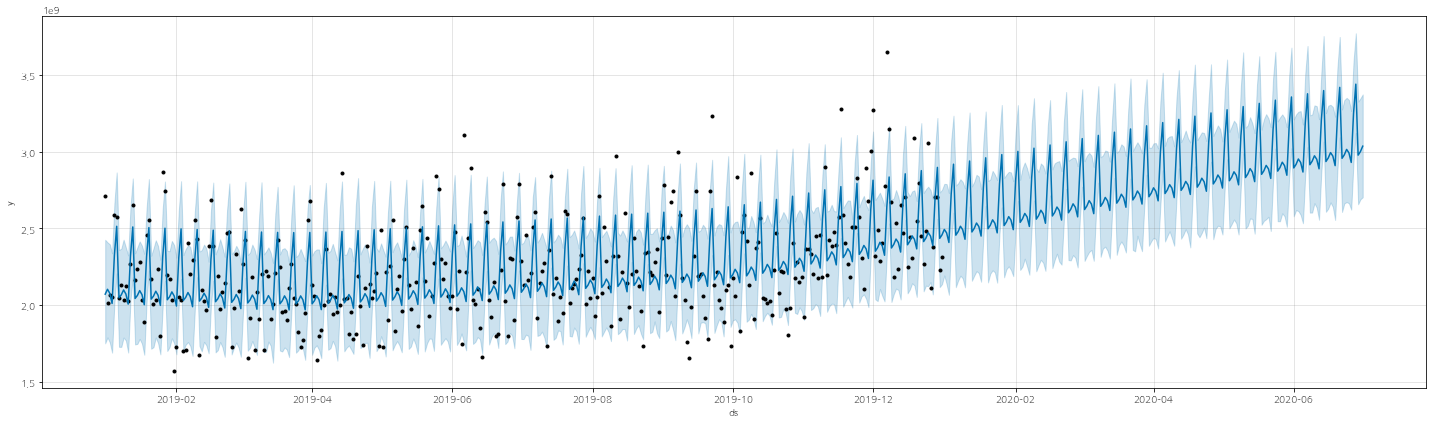

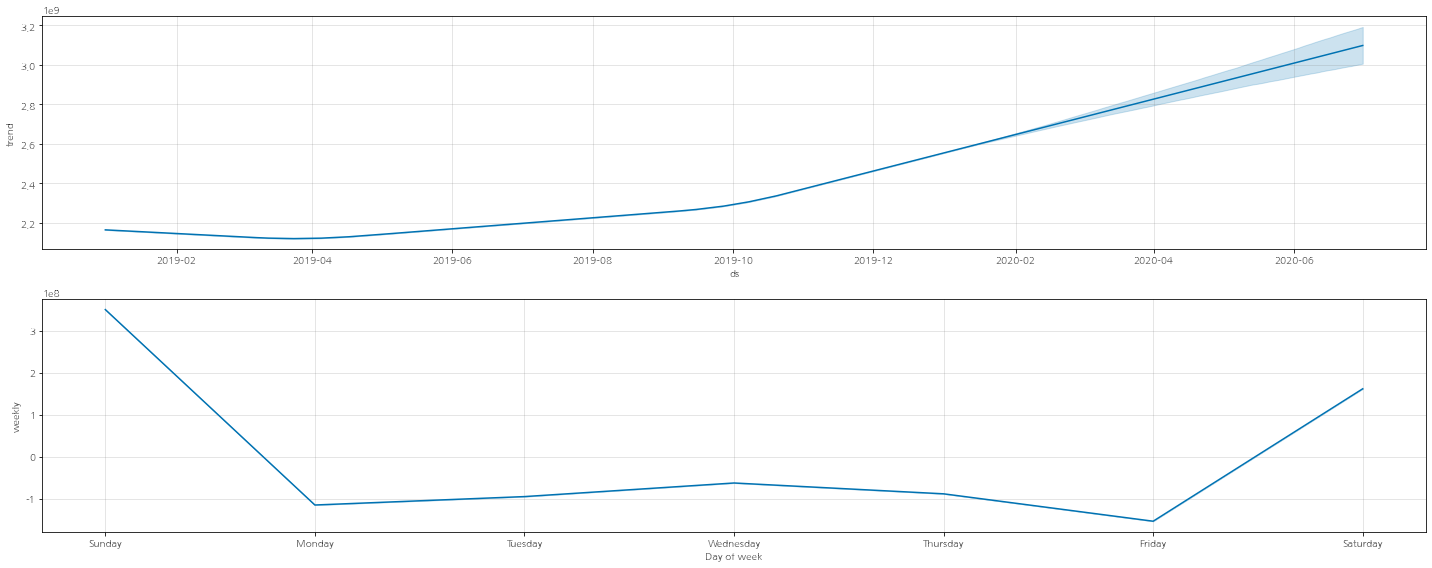

In [18]:
# 예측 추이 파악
m.plot(forecast, figsize=(20, 6));

# 구성요소별 추세
m.plot_components(forecast, figsize=(20, 8));

### linear, yearly 추세

In [19]:
# 공휴일, linear, year 1년치 추세 파악
m = Prophet(yearly_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=183) # 6월까지
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


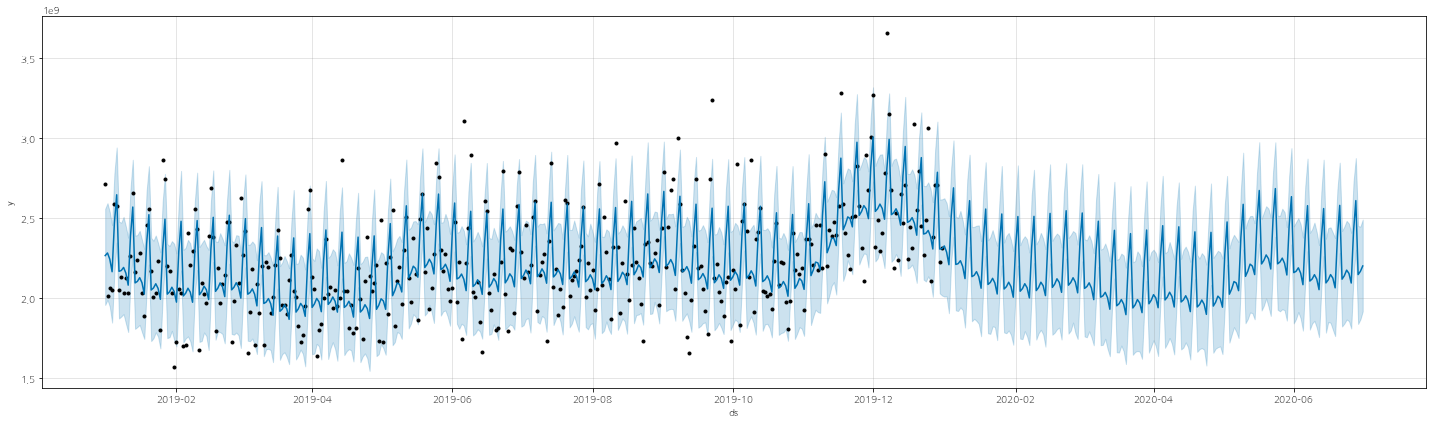

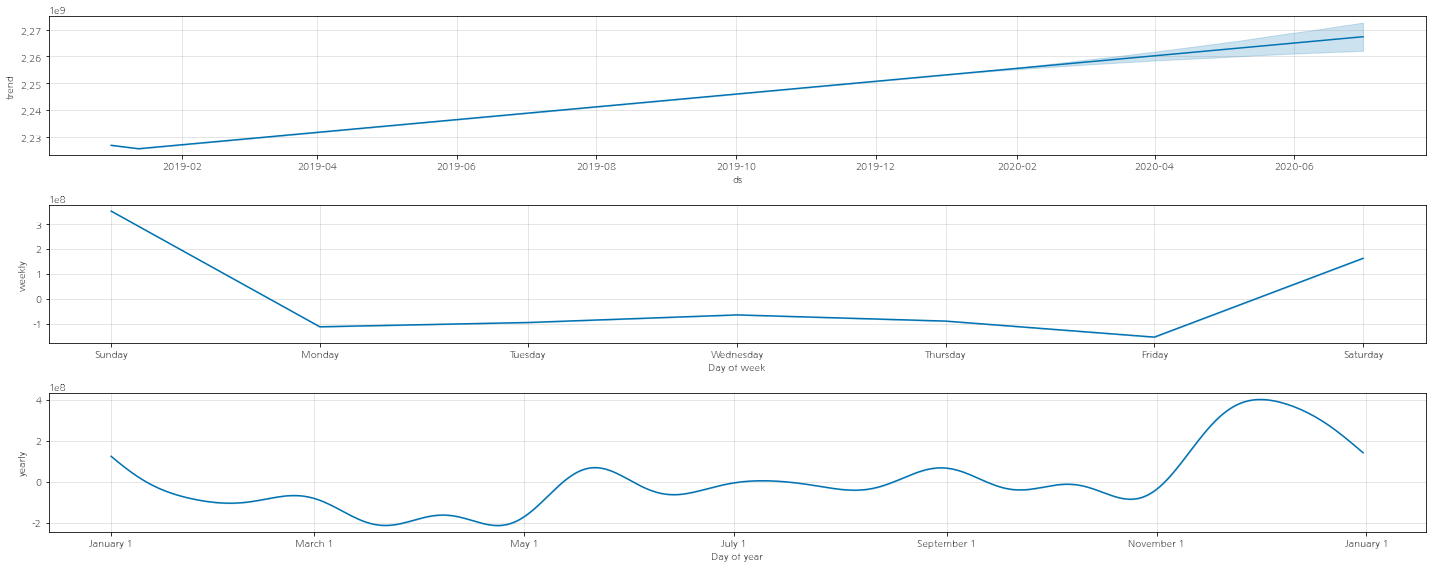

In [20]:
# 예측 추이 파악
m.plot(forecast, figsize=(20, 6));

# 구성요소별 추세
m.plot_components(forecast, figsize=(20, 8));

### linear, holiday(`holiday2`), yearly 추세 = multiplicative

In [ ]:
newyears = pd.DataFrame({
    'holiday': '신정',
    'ds': pd.to_datetime(['2019-01-01']),
    'lower_window':0,
    'upper_window': 2, 
})

lasts = pd.DataFrame({
    'holiday': '연말',
    'ds': pd.to_datetime(['2019-12-25']),
    'lower_window':0,
    'upper_window': 5, 
})

firsts = pd.DataFrame({
    'holiday': '연초',
    'ds': pd.to_datetime(['2019-01-01']),
    'lower_window':0,
    'upper_window': 16, 
})

seolnals = pd.DataFrame({
    'holiday': '설날',
    'ds': pd.to_datetime(['2019-02-04', '2019-02-05', '2019-02-06']),
    'lower_window': -30,
    'upper_window': 2,
})

chuseoks = pd.DataFrame({
    'holiday': '추석',
    'ds': pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14']),
    'lower_window': -30,
    'upper_window': 2, 
})

holidays = pd.DataFrame({
  'holiday': '공휴일',
  'ds': pd.to_datetime(['2019-03-01', '2019-05-05', '2019-05-06', '2019-05-12', '2019-06-06',
                        '2019-07-17', '2019-08-15', '2019-10-03', '2019-10-09']),
  'lower_window': 0,
  'upper_window': 0,
})

specials = pd.DataFrame({
  'holiday': '특별한날',
  'ds': pd.to_datetime(['2019-02-14', '2019-03-14', '2019-05-01',
                        '2019-05-08', '2019-05-15', '2019-07-12', '2019-07-22', '2019-08-11',
                        '2019-11-11']),
  'lower_window': 0,
  'upper_window': 0,
})

holiday_df = pd.concat((newyears, seolnals, chuseoks, holidays, specials))
holiday_df

In [23]:
# 공휴일, linear, year 1년치 추세 파악
m = Prophet(yearly_seasonality=True, holidays=holiday_df, seasonality_mode='multiplicative')
m.fit(train)
future = m.make_future_dataframe(periods=183) # 6월까지
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


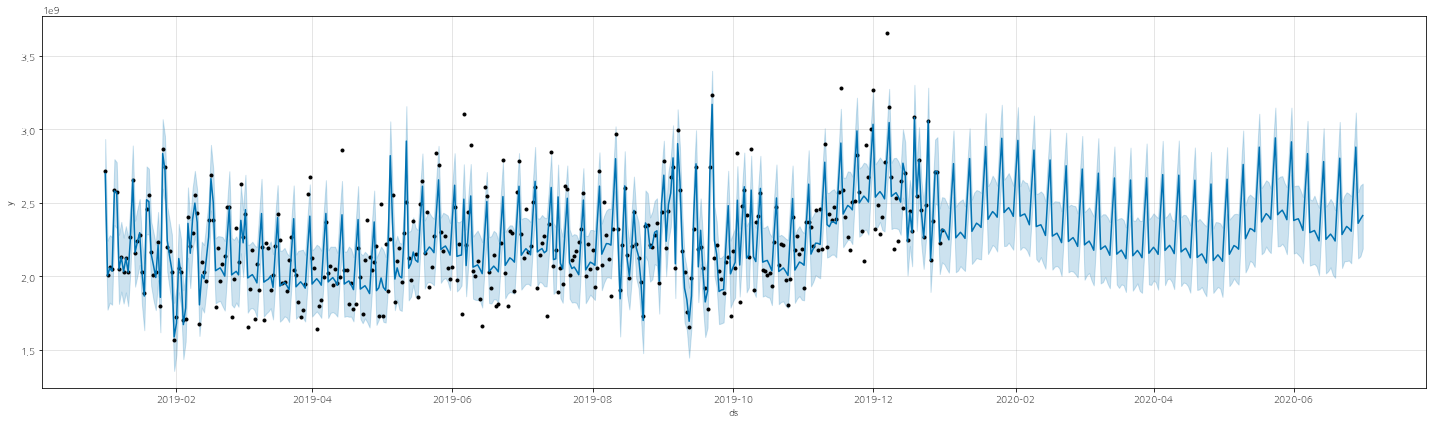

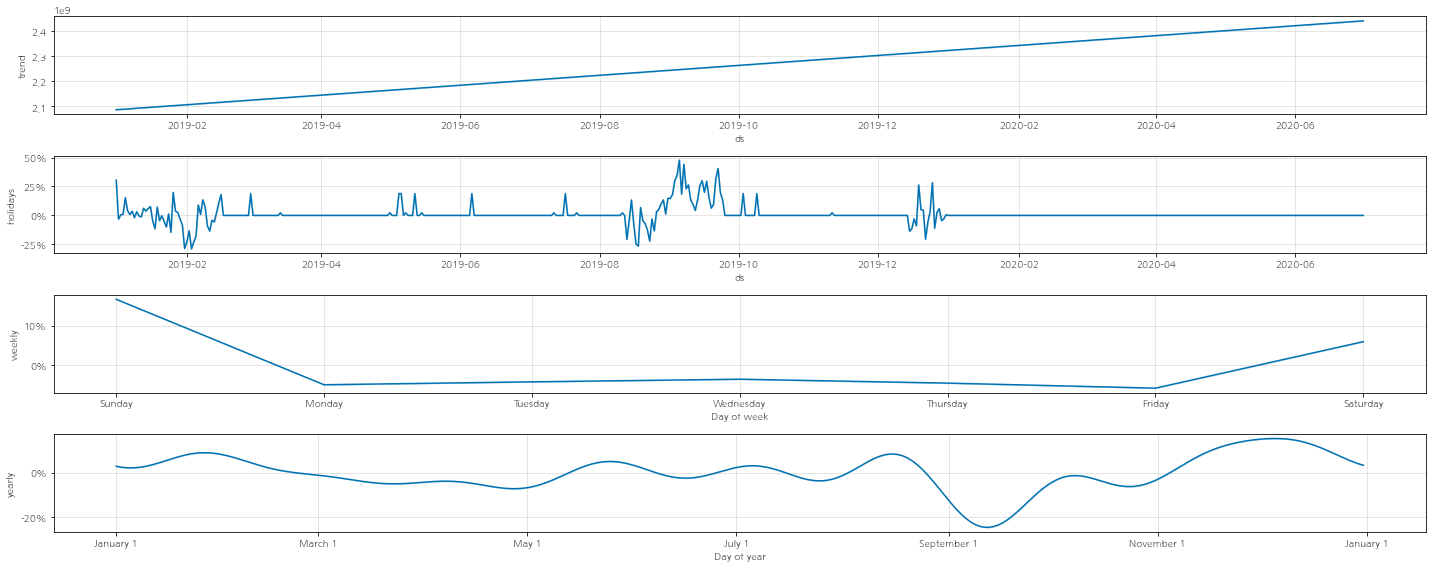

In [24]:
# 예측 추이 파악
m.plot(forecast, figsize=(20, 6));

# 구성요소별 추세
m.plot_components(forecast, figsize=(20, 8));

### logistic, holiday, yearly 추세
- holiday effect underfit되었다고 생각하여 `holidays_prior_scale` 조정.
- test : 2020년 6월까지로 변경.

In [124]:
# 공휴일 반영하지 않은 prophet 모델로 추세 파악
m = Prophet(growth='logistic', holidays=holiday_df, yearly_seasonality=True)
m.fit(train)
forecast = m.predict(test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


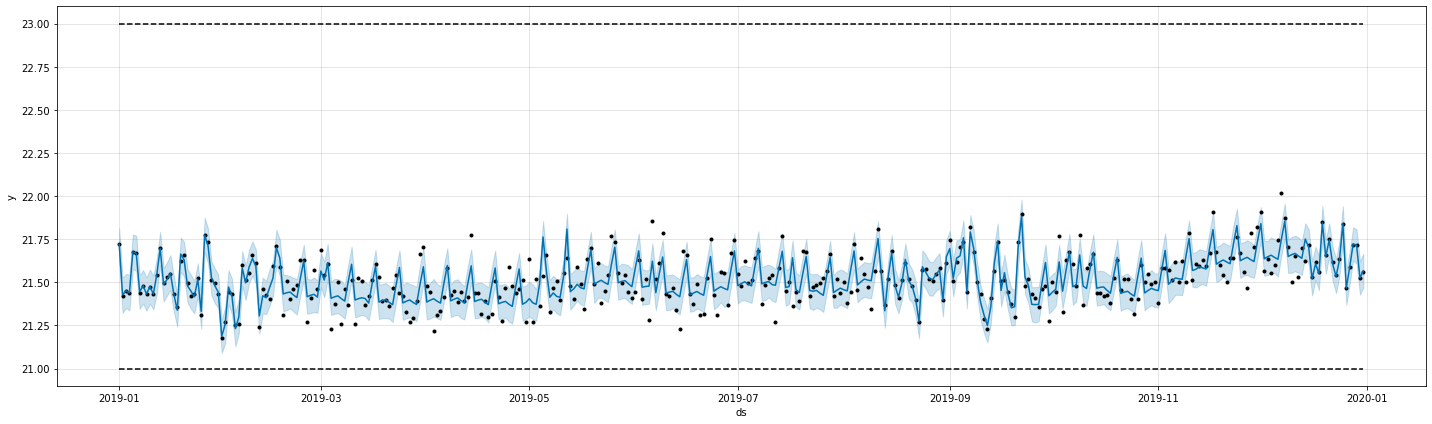

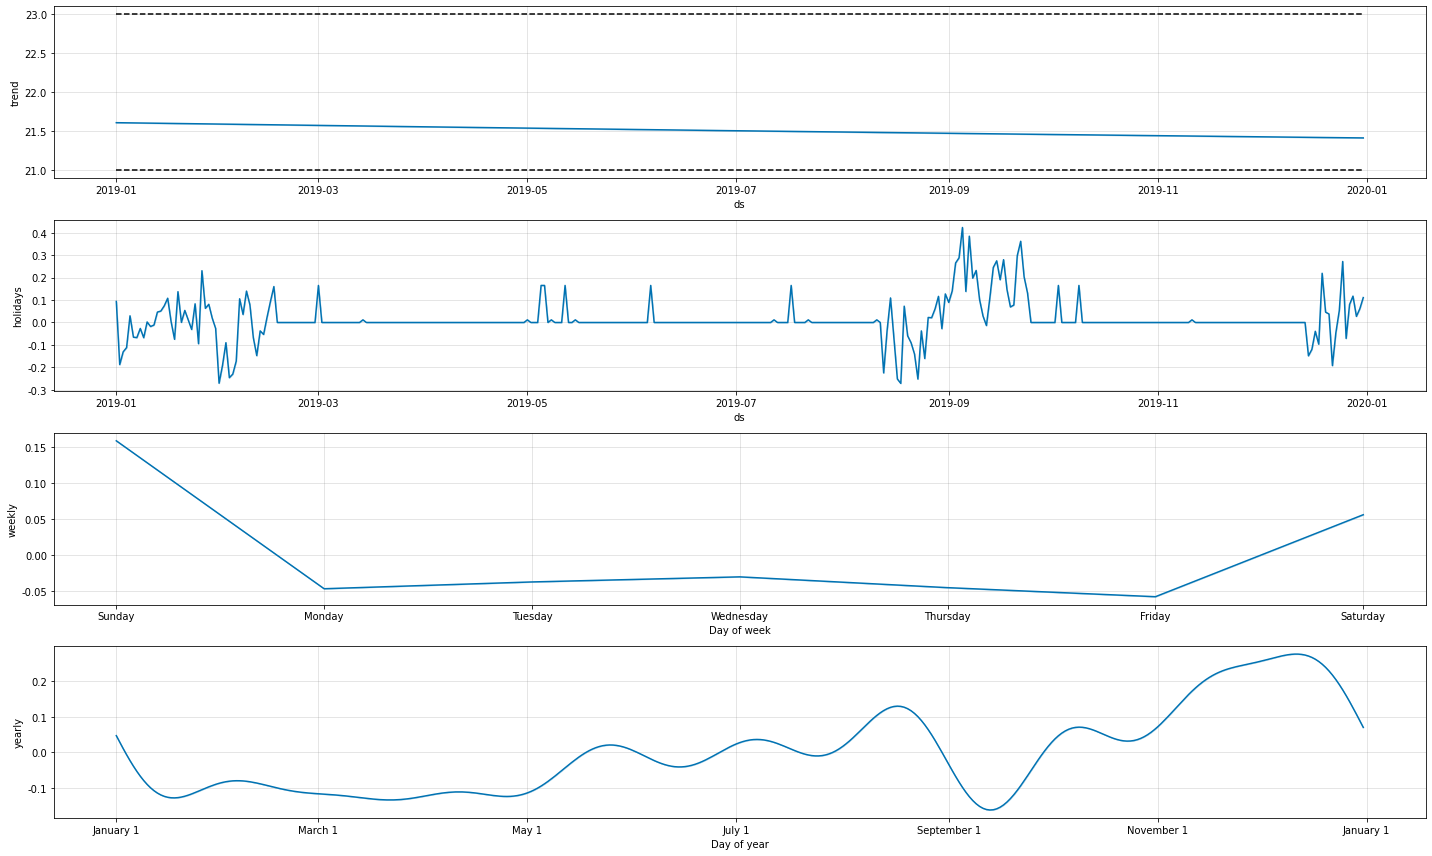

In [125]:
# 예측 추이 파악
m.plot(forecast, figsize=(20, 6));

# 구성요소별 추세
m.plot_components(forecast, figsize=(20, 12));

In [ ]:
# Python
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecas

## _2_. 시간대별 취급액 합계

In [15]:
# 시간대별 취급액 및 판매량 합계
hourly = pd.DataFrame(data.groupby(by='날짜시간', as_index=True).agg({'취급액':'sum', '판매량':'sum'}))

# 취급액
scaler = StandardScaler()
scaler.fit(hourly[['취급액']])
hourly['취급액_scaled'] = scaler.transform(hourly[['취급액']])
hourly['취급액_log'] = np.log1p(hourly['취급액'])

# 판매량
scaler = StandardScaler()
scaler.fit(hourly[['판매량']])
hourly['판매량_scaled'] = scaler.transform(hourly[['판매량']])
hourly['판매량_log'] = np.log1p(hourly['판매량'])

In [18]:
# Prophet 모델에 맞게 데이터셋 구성
train = hourly.reset_index(drop=False)[['날짜시간', '취급액']].rename(columns={'날짜시간':'ds', '취급액':'y'})
test = hourly.reset_index(drop=False)[['날짜시간']].rename(columns={'날짜시간':'ds'})
display(train)
display(test)

,ds,y
0,2019-01-01 06:00:00,32696000.0
1,2019-01-01 07:00:00,47878000.0
2,2019-01-01 08:00:00,99736000.0
3,2019-01-01 09:00:00,90973000.0
4,2019-01-01 10:00:00,259678000.0
...,...,...
7110,2019-12-31 19:00:00,177729000.0
7111,2019-12-31 20:00:00,143410000.0
7112,2019-12-31 21:00:00,219941000.0
7113,2019-12-31 22:00:00,104917000.0


,ds
0,2019-01-01 06:00:00
1,2019-01-01 07:00:00
2,2019-01-01 08:00:00
3,2019-01-01 09:00:00
4,2019-01-01 10:00:00
...,...
7110,2019-12-31 19:00:00
7111,2019-12-31 20:00:00
7112,2019-12-31 21:00:00
7113,2019-12-31 22:00:00


### holiday effect 반영하지 않았을 때


In [ ]:
# 공휴일 반영한 prophet 모델
m = Prophet()
m.fit(train)
forecast = m.predict(test)

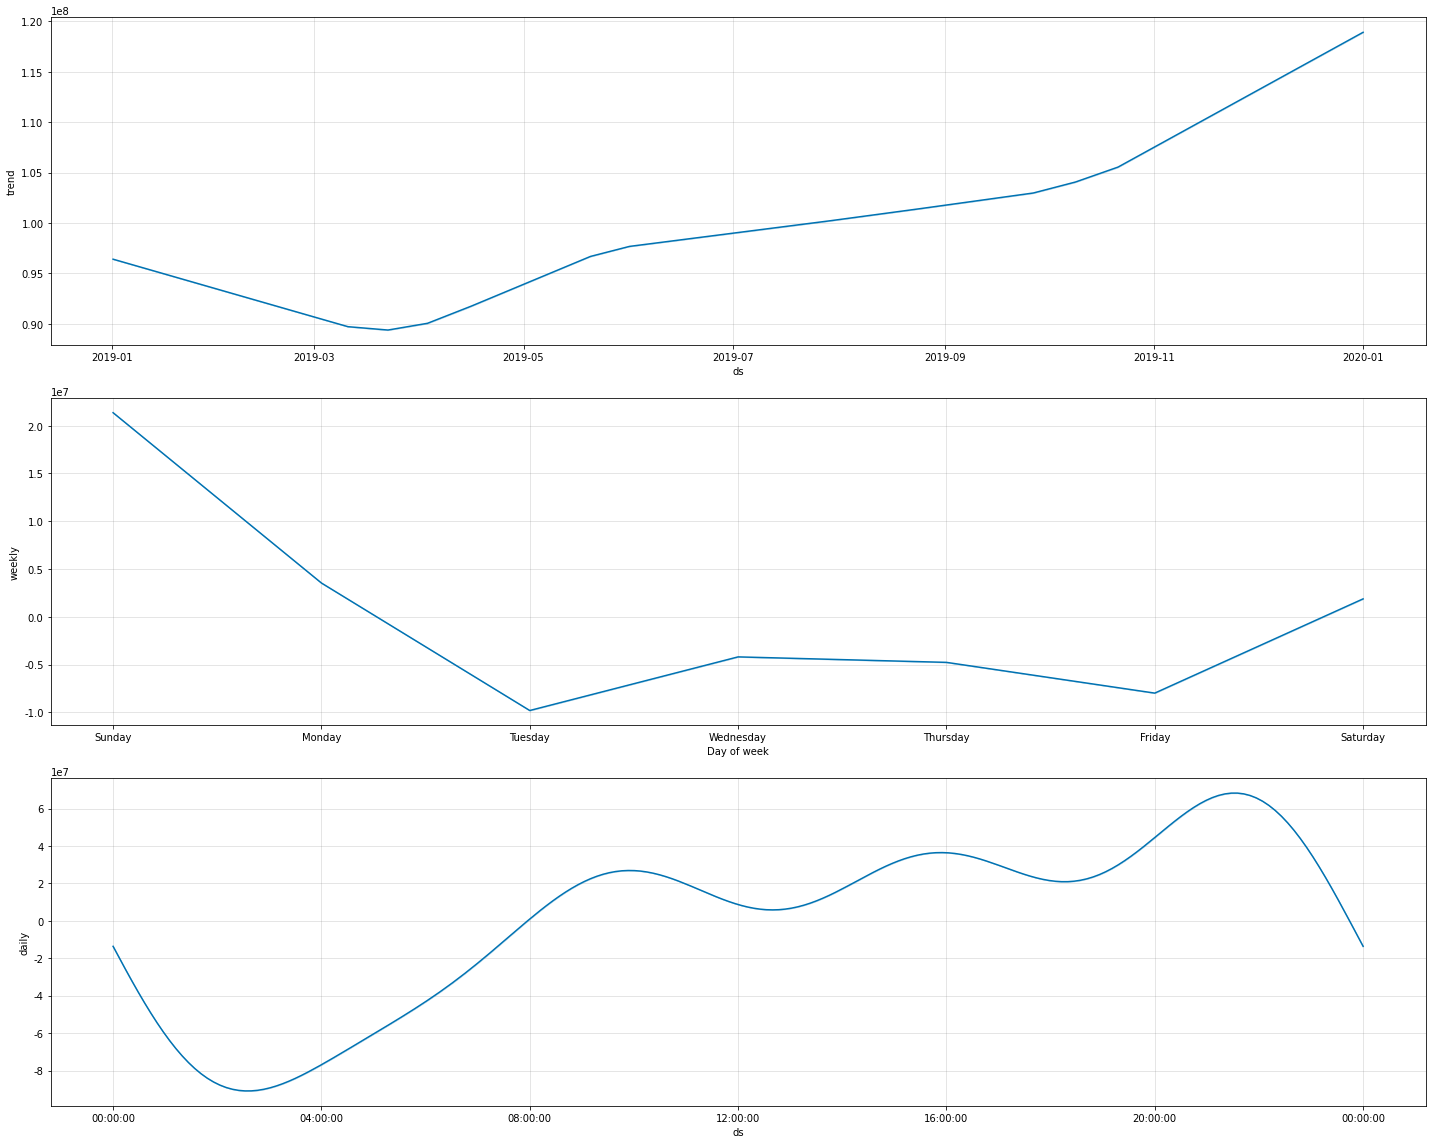

In [46]:
# 각 component별 시계열 파악
m.plot_components(forecast, figsize=(20, 16));

### holiday effect 반영했을 때

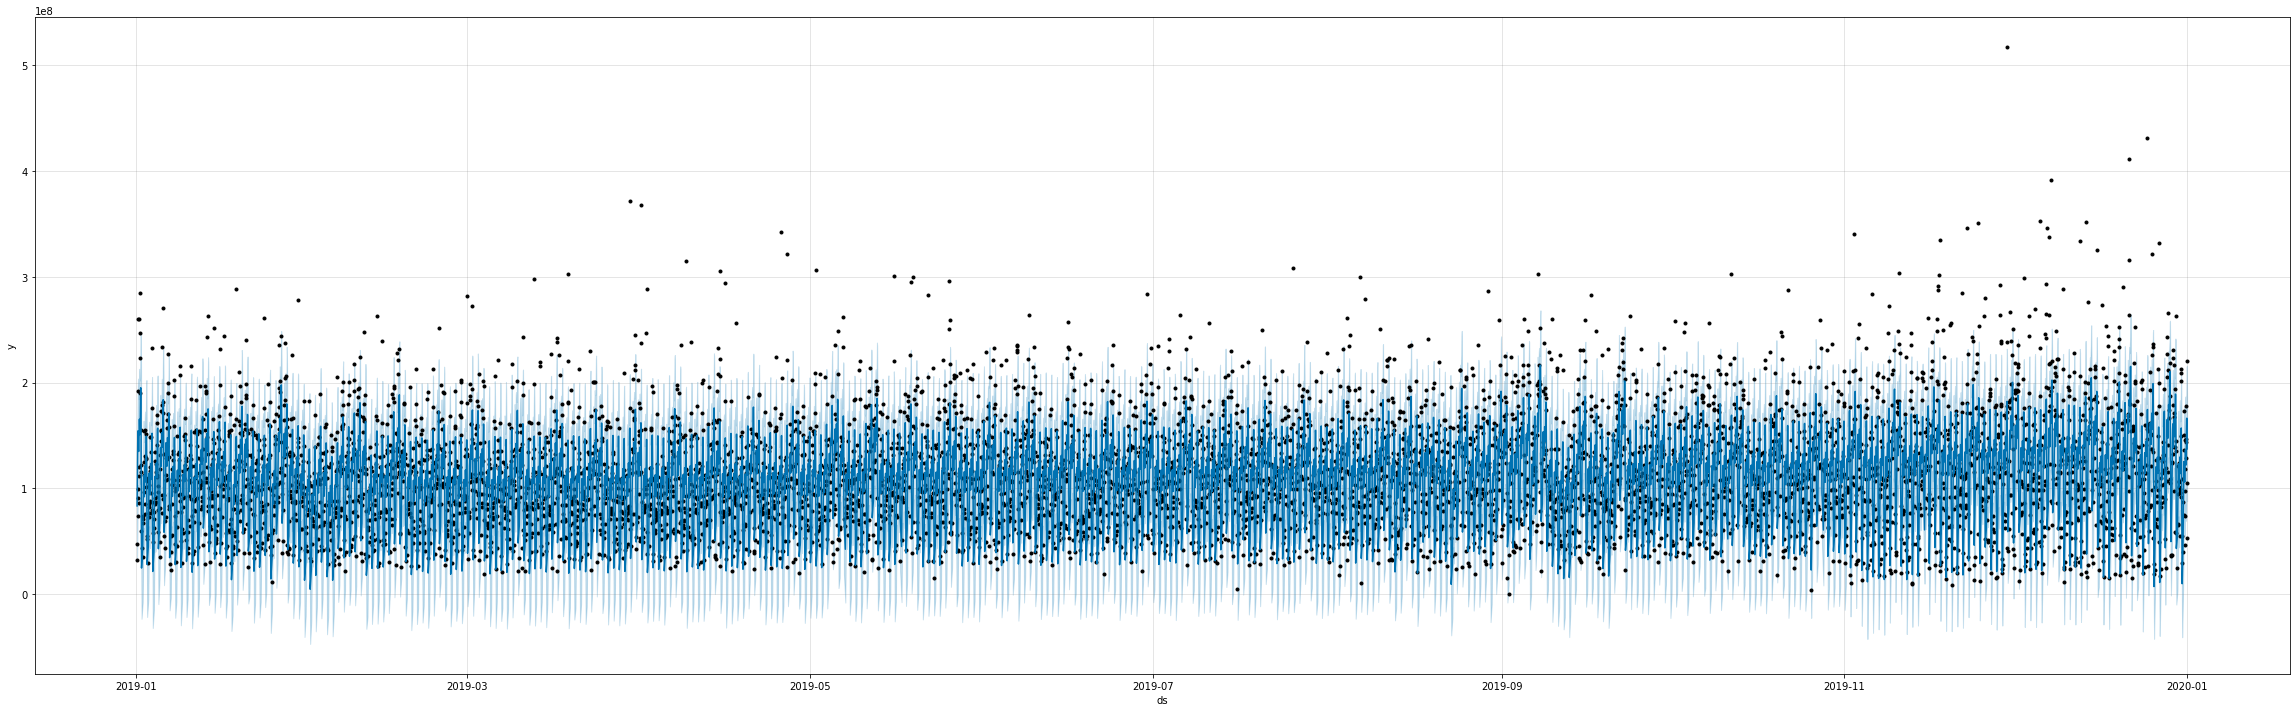

In [21]:
# 공휴일 반영한 prophet 모델
m = Prophet(holidays=holiday_df)
m.fit(train)
forecast = m.predict(test)
m.plot(forecast, figsize=(32, 10));

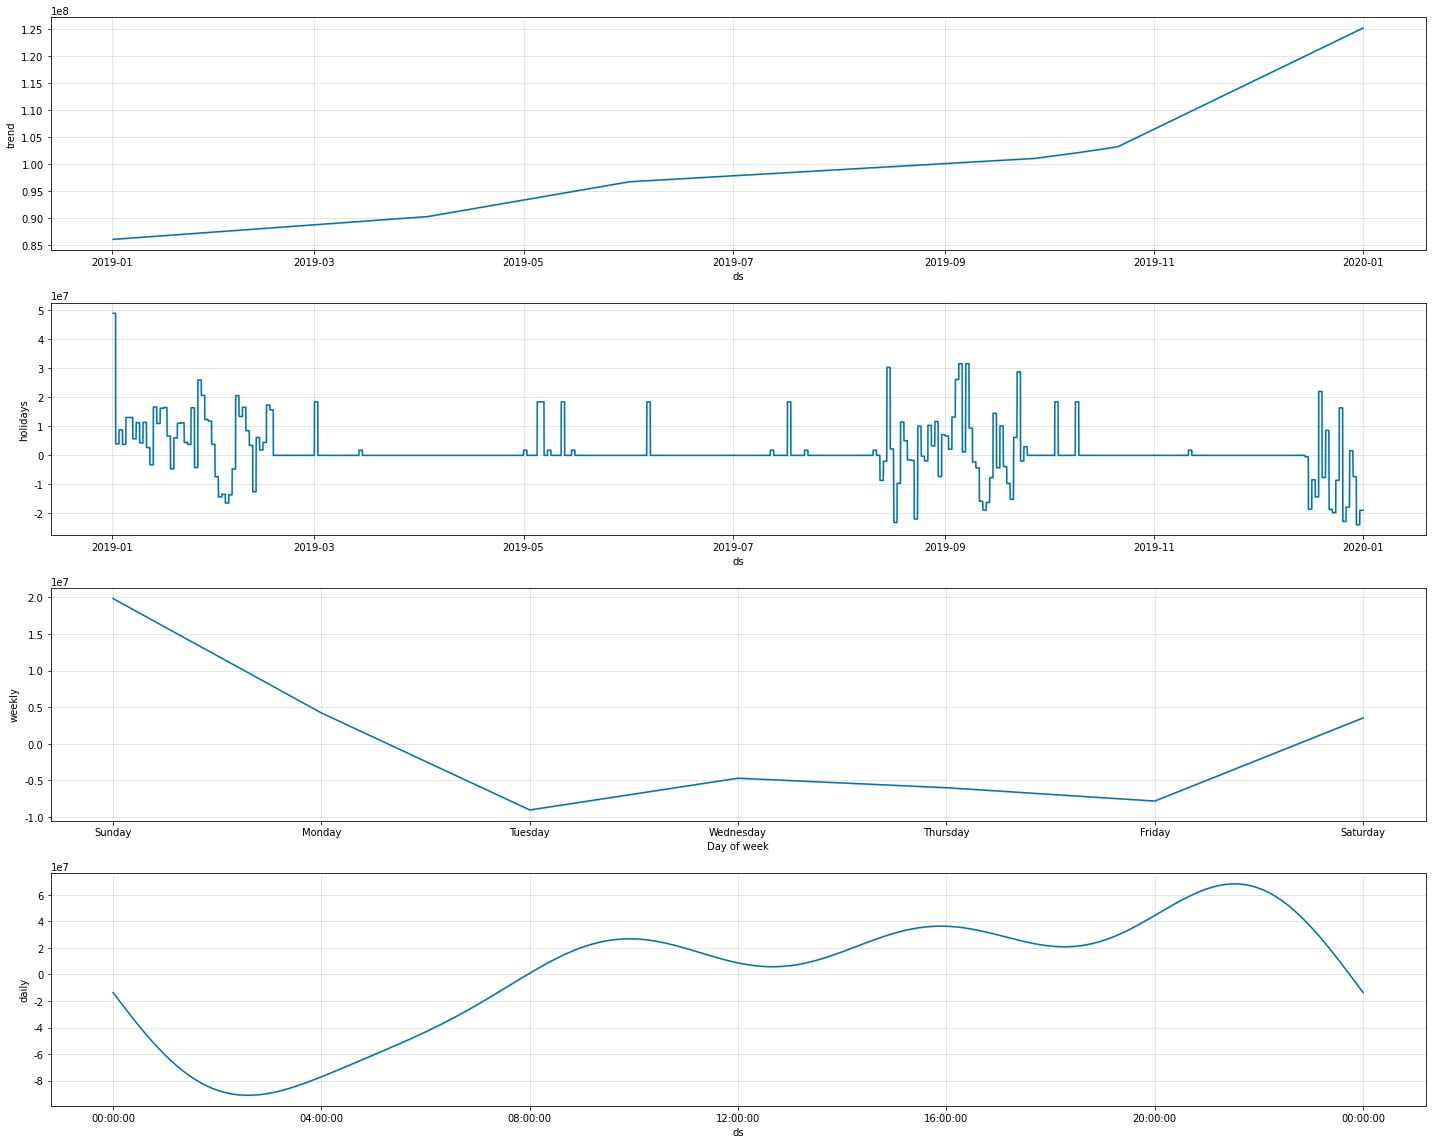

In [22]:
# 각 component별 시계열 파악
m.plot_components(forecast, figsize=(20, 16));

In [44]:
# 공휴일 영향
for holiday in holiday_list:
    print(f"========== {holiday} ==========")
    temp = forecast[forecast[holiday].abs() > 0][['ds', holiday]]
    temp['날짜'] = temp['ds'].dt.date
    temp = pd.DataFrame(temp.groupby(by='날짜')[holiday].mean()).sort_values(by=holiday, ascending=False)
    if len(temp)>15:
        display(temp[:15])
    else:
        display(temp)
    print()

========== 신정 ==========


,신정
날짜,
2019-01-01,2.446726e+07
2019-01-03,4.390289e+06
2019-01-02,1.975036e+06



========== 연초 ==========


,연초
날짜,
2019-01-01,2.446726e+07
2019-01-17,1.375311e+07
2019-01-16,8.549520e+06
2019-01-13,8.389051e+06
2019-01-05,6.471425e+06
2019-01-10,4.765944e+06
2019-01-03,4.390289e+06
2019-01-04,3.792194e+06
2019-01-08,3.476055e+06



========== 연말 ==========


,연말
날짜,
2019-12-19,2.201914e+07
2019-12-25,1.636004e+07
2019-12-21,8.593954e+06
2019-12-28,1.620925e+06
2019-12-15,-4.846513e+05
2019-12-29,-7.318445e+06
2019-12-20,-7.628085e+06
2019-12-17,-8.414770e+06
2019-12-24,-8.581202e+06



========== 설날 ==========


,설날
날짜,
2019-02-06,1.029400e+07
2019-02-02,9.406918e+06
2019-02-07,1.177004e+06
2019-02-05,-2.348358e+06
2019-02-04,-6.794258e+06
2019-02-08,-1.267581e+07
2019-02-03,-1.591125e+07



========== 설날기간 ==========


,설날기간
날짜,
2019-02-08,2.923324e+07
2019-01-26,2.595730e+07
2019-01-15,2.259521e+07
2019-01-27,2.067593e+07
2019-02-15,1.734621e+07
2019-01-24,1.639347e+07
2019-02-16,1.568579e+07
2019-01-28,1.234392e+07
2019-02-07,1.220792e+07



========== 추석 ==========


,추석
날짜,
2019-09-15,1.339553e+07
2019-09-16,1.089486e+07
2019-09-11,7.790334e+06
2019-09-10,1.173450e+06
2019-09-14,-3.839722e+06
2019-09-13,-8.117699e+06
2019-09-12,-9.444913e+06



========== 추석기간 ==========


,추석기간
날짜,
2019-09-05,3.157904e+07
2019-09-07,3.157004e+07
2019-09-22,2.876429e+07
2019-09-04,2.613492e+07
2019-09-03,1.319342e+07
2019-08-15,1.189565e+07
2019-08-29,1.167799e+07
2019-08-19,1.144490e+07
2019-08-27,1.034390e+07



========== 공휴일 ==========


,공휴일
날짜,
2019-03-01,1.841586e+07
2019-05-05,1.841586e+07
2019-05-06,1.841586e+07
2019-05-12,1.841586e+07
2019-06-06,1.841586e+07
2019-07-17,1.841586e+07
2019-08-15,1.841586e+07
2019-10-03,1.841586e+07
2019-10-09,1.841586e+07



========== 특별한날 ==========


,특별한날
날짜,
2019-02-14,1.780135e+06
2019-03-14,1.780135e+06
2019-05-01,1.780135e+06
2019-05-08,1.780135e+06
2019-05-15,1.780135e+06
2019-07-12,1.780135e+06
2019-07-22,1.780135e+06
2019-08-11,1.780135e+06
2019-11-11,1.780135e+06
